<a href="https://colab.research.google.com/github/sameekshya1999/From-Classical-to-Complex-Comparing-MSE-Zeta-and-Hybrid-Optimizers-in-Linear-Regression/blob/main/From_Classical_to_Complex_Comparing_MSE%2C_Zeta%2C_and_Hybrid_Optimizers_in_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theoretical Analysis of Optimization Methods for Linear Regression
**Author:** Samiksha BC, Indiana University  
**Date:** July 2023  
**Department:** Computer Science

## 1. Introduction
Linear regression is a fundamental statistical method for modeling the relationship between variables. We compare three optimization approaches:
1. Pure Gradient Descent (GD)
2. Riemann Zeta Function-based Optimization
3. Hybrid Approach combining Zeta and Mean Squared Error (MSE)



In [ ]:
!pip install numpy matplotlib sympy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

**1. Pure Gradient Descent**

Gradient Descent is a foundational optimization algorithm that minimizes a loss function by iteratively adjusting parameters in the direction of the steepest descent. In the context of linear regression, it aims to minimize the Mean Squared Error (MSE) between predicted and actual values. The update rules for the slope (m) and intercept (b) are derived from the partial derivatives of the MSE loss function with respect to each parameter. This method is simple, interpretable, and widely used but may suffer from slow convergence or getting stuck in suboptimal minima, especially if the loss landscape is complex or non-convex.

**2. Riemann Zeta Optimizer**
This method introduces a novel loss function based on the Riemann Zeta function, traditionally known from analytic number theory. Here, the residuals (differences between predicted and actual values) are transformed and passed through the zeta function to create a non-standard, non-linear loss landscape. The optimizer minimizes the reciprocal of the zeta function values of transformed residuals, effectively assigning diminishing penalties to certain error distributions. The use of automatic differentiation via a custom autograd.Function allows gradients to be computed even for this exotic loss. This method can introduce robustness and unique convergence properties but is less interpretable and depends heavily on numerical approximation.

**3. Hybrid Optimizer (Zeta + MSE)**
The hybrid approach combines the classical MSE loss with the zeta-based loss to leverage the strengths of both. The MSE ensures convergence to a statistically optimal linear fit, while the zeta component introduces non-linearity that may help escape local minima or outlier sensitivity. By adjusting the zeta_weight parameter, one can control the balance between conventional fitting accuracy and the exploratory properties introduced by the zeta term. This hybrid model often results in more stable and potentially more generalizable optimization outcomes, especially in datasets with noise or non-Gaussian error distributions.

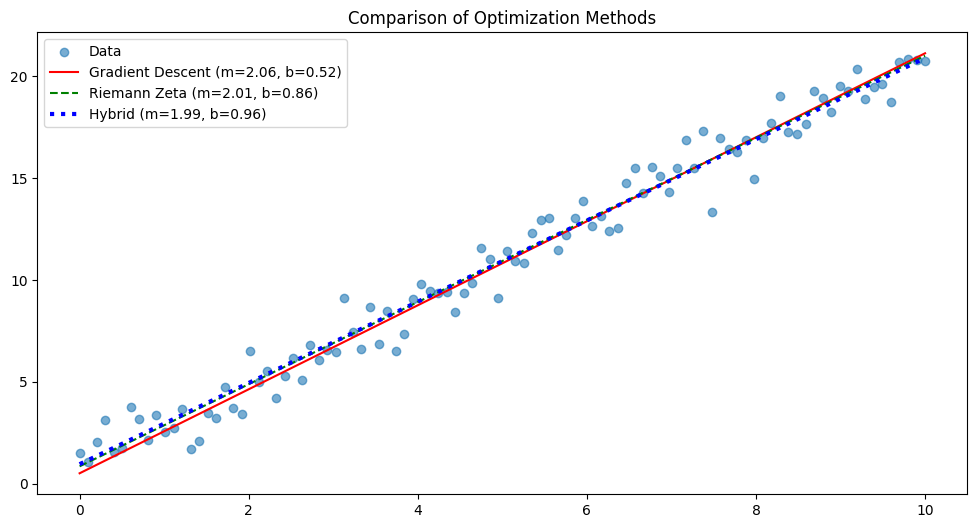


Final Results:
Gradient Descent: m = 2.0607, b = 0.5154
Riemann Zeta: m = 2.0146, b = 0.8566
Hybrid: m = 1.9929, b = 0.9612


In [ ]:
import numpy as np
import torch
from scipy.special import zeta as scipy_zeta
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, 100)

# 1. Pure Gradient Descent
def gradient_descent(x, y, lr=0.01, epochs=100):
    m, b = 0, 0
    n = len(x)
    history = []

    for epoch in range(epochs):
        y_pred = m * x + b
        dm = (-2/n) * sum(x * (y - y_pred))
        db = (-2/n) * sum(y - y_pred)
        m -= lr * dm
        b -= lr * db

        if epoch % 20 == 0:
            loss = np.mean((y - y_pred)**2)
            history.append((epoch, m, b, loss))

    return m, b, history

# 2. Riemann Zeta Optimizer
class ZetaApprox(torch.autograd.Function):
    @staticmethod
    def forward(ctx, s):
        s_np = s.detach().cpu().numpy()
        result = torch.tensor(scipy_zeta(s_np), device=s.device, dtype=s.dtype)
        ctx.save_for_backward(s)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        s, = ctx.saved_tensors
        h = 1e-5
        s_plus = s + h
        s_minus = s - h
        deriv = (scipy_zeta(s_plus.detach().cpu().numpy()) -
                scipy_zeta(s_minus.detach().cpu().numpy())) / (2*h)
        return grad_output * torch.tensor(deriv, device=s.device, dtype=s.dtype)

def riemann_optimize(x, y, lr=0.01, epochs=200):
    x_t = torch.tensor(x, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    params = torch.tensor([1.0, 0.0], requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr)
    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        m, b = params
        y_pred = m * x_t + b
        residuals = y_t - y_pred
        transformed = 2.0 + 0.1*torch.abs(residuals)
        loss = torch.mean(1.0 / ZetaApprox.apply(transformed))
        loss.backward()
        optimizer.step()

        if epoch % 40 == 0:
            history.append((epoch, params[0].item(), params[1].item(), loss.item()))

    return params[0].item(), params[1].item(), history

# 3. Hybrid Optimizer (Zeta + MSE)
def hybrid_optimize(x, y, lr=0.01, epochs=300, zeta_weight=0.7):
    x_t = torch.tensor(x, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    params = torch.tensor([1.0, 0.0], requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=lr)
    history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        m, b = params
        y_pred = m * x_t + b
        residuals = y_t - y_pred

        # Zeta component
        transformed = 2.0 + 0.1*torch.abs(residuals)
        zeta_loss = torch.mean(1.0 / ZetaApprox.apply(transformed))

        # MSE component
        mse_loss = torch.mean((y_t - y_pred)**2)

        loss = zeta_weight * zeta_loss + (1-zeta_weight) * mse_loss
        loss.backward()
        optimizer.step()

        if epoch % 40 == 0:
            history.append((epoch, params[0].item(), params[1].item(), loss.item()))

    return params[0].item(), params[1].item(), history

# Run all three methods
gd_m, gd_b, gd_hist = gradient_descent(x, y)
zeta_m, zeta_b, zeta_hist = riemann_optimize(x, y)
hybrid_m, hybrid_b, hybrid_hist = hybrid_optimize(x, y)

# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data', alpha=0.6)
plt.plot(x, gd_m*x + gd_b, 'r-', label=f'Gradient Descent (m={gd_m:.2f}, b={gd_b:.2f})')
plt.plot(x, zeta_m*x + zeta_b, 'g--', label=f'Riemann Zeta (m={zeta_m:.2f}, b={zeta_b:.2f})')
plt.plot(x, hybrid_m*x + hybrid_b, 'b:', linewidth=3,
         label=f'Hybrid (m={hybrid_m:.2f}, b={hybrid_b:.2f})')
plt.legend()
plt.title('Comparison of Optimization Methods')
plt.show()

# Print final results
print("\nFinal Results:")
print(f"Gradient Descent: m = {gd_m:.4f}, b = {gd_b:.4f}")
print(f"Riemann Zeta: m = {zeta_m:.4f}, b = {zeta_b:.4f}")
print(f"Hybrid: m = {hybrid_m:.4f}, b = {hybrid_b:.4f}")